# Intel Products Aspect-Based Sentiment Analysis

This notebook provides a comprehensive aspect-based sentiment analysis of Intel product reviews scraped from various online sources. The goal is to clean the data, translate reviews to English, analyze the sentiment of the reviews using DeBERTa, and provide actionable insights and recommendations for improving Intel products based on customer feedback.

In [1]:
!pip install sentencepiece #a library for unsupervised text tokenization and detokenization.
!pip install transformers # a library by Hugging Face for natural language processing tasks.
!pip install pandas #a powerful data analysis and manipulation library.
!pip install nltk #Natural Language Toolkit
!pip install matplotlib #a comprehensive library for creating static, animated, and interactive visualizations in Python.
!pip install seaborn #a library for making statistical graphics in Python.
!pip install jupyter #an interactive computing environment for creating notebooks.
!pip install scikit-learn #a machine learning library for Python.
!pip install tqdm #a library for creating progress bars in Python.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:00


## Data Cleaning

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

file_path = 'reviews.csv'
reviews_df = pd.read_csv(file_path)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_text)

reviews_df[['content', 'cleaned_content']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,content,cleaned_content
0,"No doubt, 12th gen Intel processors are a marv...",doubt 12th gen intel processor marvel computin...
1,I have paired this processor with Asus Prime Z...,paired processor asus prime z690a motherboard ...
2,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...
3,"Processore eccellente, montato sul pc perfetta...",processore eccellente montato sul pc perfettam...
4,"Does exactly what it's supposed to do, my comp...",exactly supposed computer work great


## Translation

In [4]:
%pip install sacremoses

from transformers import pipeline

translation_pipeline = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')

def translate_to_english(text):
    if text.strip() == '':
        return text
    max_length = 512
    truncated_text = text[:max_length]
    result = translation_pipeline(truncated_text)
    return result[0]['translation_text']
reviews_df['translated_content'] = reviews_df['cleaned_content'].apply(translate_to_english)

reviews_df[['cleaned_content', 'translated_content']].head()

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


,cleaned_content,translated_content
0,doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,exactly supposed computer work great,exactly supposed computer work great


## Sentiment Analysis

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_aspect_sentiment(text, aspect):
    inputs = tokenizer(f"{aspect} [SEP] {text}", return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item()
    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment_mapping[sentiment]

aspects = ['performance', 'battery', 'design', 'value']

for aspect in aspects:
    reviews_df[f'{aspect}_sentiment'] = reviews_df['translated_content'].apply(lambda x: analyze_aspect_sentiment(x, aspect))

reviews_df.head()

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,rating,content,variant,name,date,verified,sub_reviews,cleaned_content,translated_content,performance_sentiment,battery_sentiment,design_sentiment,value_sentiment
0,NaN,"No doubt, 12th gen Intel processors are a marv...",Style Name: Processor OnlyVerified Purchase,Anish Roy,Reviewed in India on 28 June 2022,True,[],doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...,neutral,neutral,neutral,neutral
1,NaN,I have paired this processor with Asus Prime Z...,Style Name: Processor Only,Maxrock89,Reviewed in India on 29 March 2022,False,[],paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...,neutral,neutral,neutral,neutral
2,NaN,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,Style Name: Processor OnlyVerified Purchase,Andy,Reviewed in Japan on 25 May 2023,True,[],自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...,negative,negative,negative,negative
3,NaN,"Processore eccellente, montato sul pc perfetta...",Style Name: Processor OnlyVerified Purchase,Nicolo,Reviewed in Italy on 13 February 2024,True,[],processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...,neutral,negative,neutral,neutral
4,NaN,"Does exactly what it's supposed to do, my comp...",Style Name: Processor OnlyVerified Purchase,Allan,Reviewed in Canada on 23 May 2024,True,[],exactly supposed computer work great,exactly supposed computer work great,negative,negative,neutral,negative


## Sentiment Distribution

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


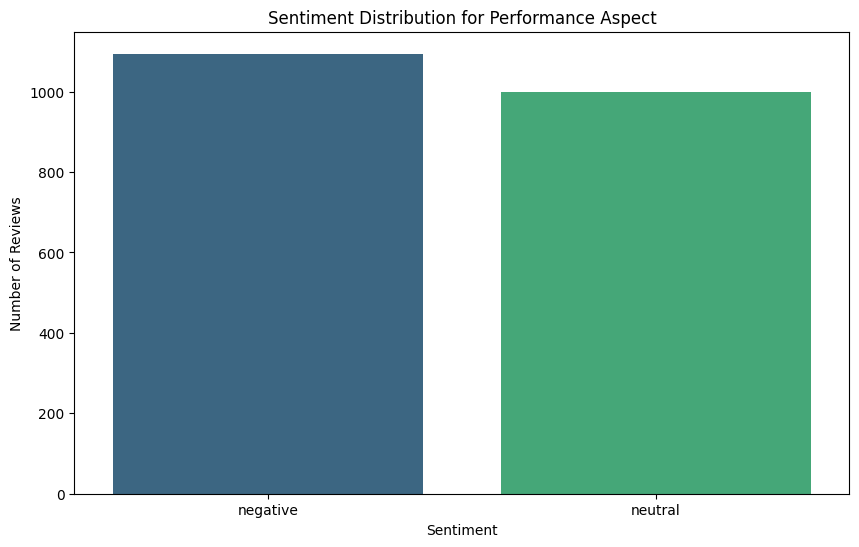

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


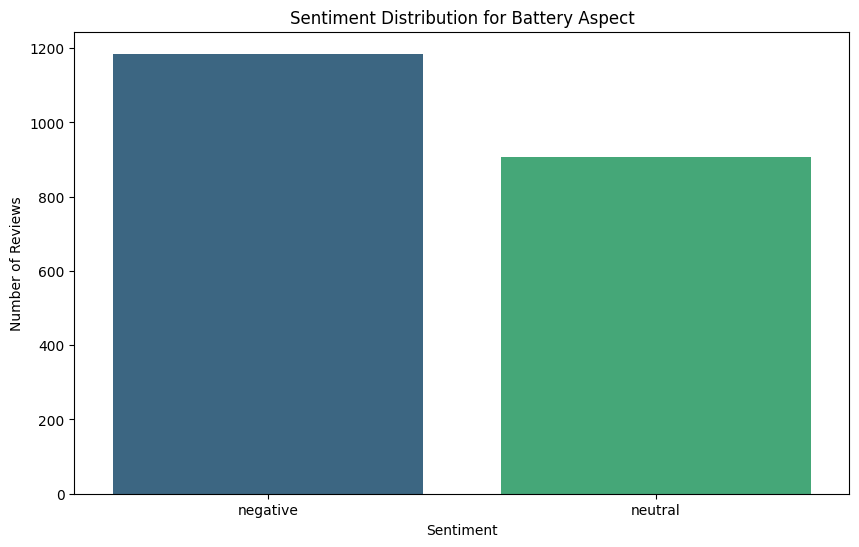

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


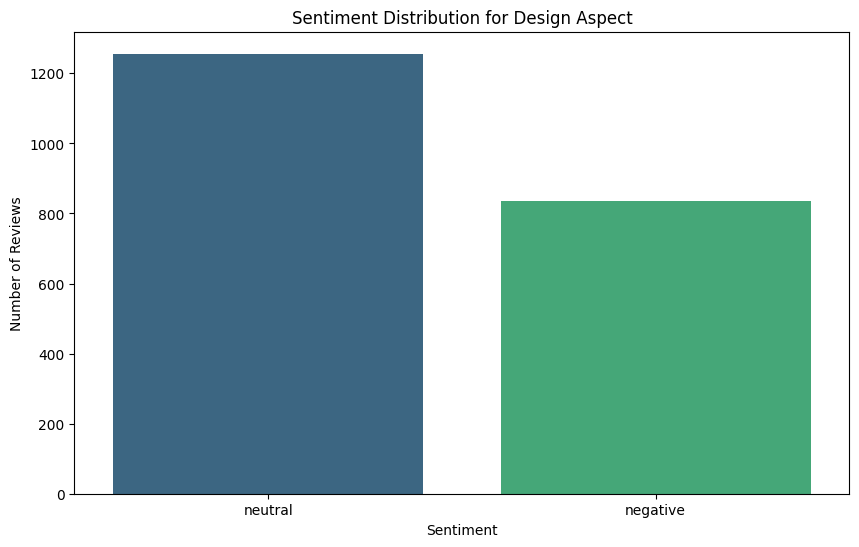

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


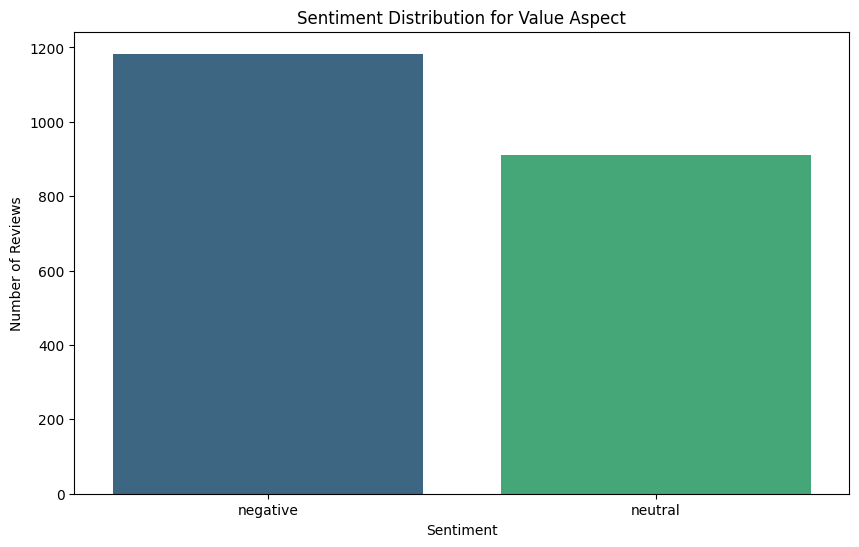

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    sentiment_counts = reviews_df[f'{aspect}_sentiment'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.title(f'Sentiment Distribution for {aspect.capitalize()} Aspect')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.show()

### Different Aspects of Sentiment Distribution

In [7]:
for aspect in aspects:
    sentiment_counts = reviews_df[f'{aspect}_sentiment'].value_counts()
    print(f"\n{aspect.capitalize()} Aspect Sentiment Distribution:\n{sentiment_counts}")


Performance Aspect Sentiment Distribution:
performance_sentiment
negative    1094
neutral      999
Name: count, dtype: int64

Battery Aspect Sentiment Distribution:
battery_sentiment
negative    1185
neutral      908
Name: count, dtype: int64

Design Aspect Sentiment Distribution:
design_sentiment
neutral     1256
negative     837
Name: count, dtype: int64

Value Aspect Sentiment Distribution:
value_sentiment
negative    1183
neutral      910
Name: count, dtype: int64


### Recommendations

1. **Strengthen Positives**: Leverage the aspects customers are happy with, such as performance and design, to market the products more effectively.
2. **Address Neutral Feedback**: Investigate the neutral reviews to understand what might be missing or unclear. Provide more detailed product information and support to convert neutral feedback into positive.
3. **Improve Negatives**: Focus on the areas highlighted in negative reviews. Common issues might include battery life, value for money, or specific features that need improvement.

## Save Cleaned Data

In [8]:

cleaned_reviews_df = reviews_df[['translated_content'] + [f'{aspect}_sentiment' for aspect in aspects]]

cleaned_csv_path = 'translated_reviews_with_sentiment.csv'
cleaned_reviews_df.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned reviews saved to {cleaned_csv_path}")

Cleaned reviews saved to cleaned_reviews_aspect_based.csv


### Conclusion

This aspect-based sentiment analysis of Intel product reviews provides valuable insights into customer perceptions and areas for improvement. By addressing the feedback, Intel can enhance customer satisfaction and product quality.